In [1]:
from __future__ import print_function
from __future__ import unicode_literals
from __future__ import division

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
import h5py

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline

# Load tensors

In [4]:
with h5py.File('tmp/train_tensor.h5', 'r') as hf:
    X = hf['features'][:]
    Y = hf['labels'][:]

In [6]:
X.shape, Y.shape

((57139, 32, 28, 1), (57139, 28))

# Split dataset

In [18]:
from sklearn.model_selection import train_test_split

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

In [20]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((45711, 32, 28, 1), (11428, 32, 28, 1), (45711, 28), (11428, 28))

# CNN

In [9]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization
from keras.callbacks import Callback

In [14]:
model = Sequential()
model.add(Conv2D(32, 3, activation='relu', padding='same', input_shape=(32, 28, 1)))
model.add(MaxPooling2D(pool_size=(1, 4), strides=(1, 1)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(28, activation='sigmoid'))

In [15]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 32, 28, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 25, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 25, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 25600)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               6553856   
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 28)                7196      
Total para

In [22]:
from IPython.display import clear_output

class PlotLosses(Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.show();
        
plot_losses = PlotLosses()

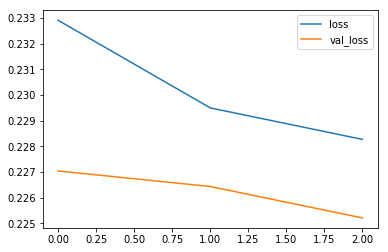

11360/11428 [============================>.] - ETA: 0stest loss: 0.225209507819
test accuracy: 0.916164571145


In [25]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.fit(X_train, y_train,
          batch_size=128,
          epochs=3,
          verbose=1,
          callbacks=[plot_losses],
          validation_data=(X_test, y_test))

score = model.evaluate(X_test, y_test)
print('test loss: {}'.format(score[0]))
print('test accuracy: {}'.format(score[1]))

In [26]:
final_ans = model.predict(X_test)

In [27]:
final_ans

array([[ 0.02341763,  0.03387096,  0.00474508, ...,  0.05816509,
         0.00840193,  0.00261827],
       [ 0.02204593,  0.03256032,  0.00445511, ...,  0.05953463,
         0.00860823,  0.00249028],
       [ 0.44681308,  0.53646952,  0.14193545, ...,  0.43772593,
         0.11002289,  0.04411549],
       ..., 
       [ 0.04651712,  0.08029124,  0.0099568 , ...,  0.14486012,
         0.02186753,  0.00560097],
       [ 0.02792577,  0.04087951,  0.00576281, ...,  0.06812568,
         0.00999662,  0.00287892],
       [ 0.02167896,  0.02898033,  0.00442073, ...,  0.04896798,
         0.00738988,  0.00247516]], dtype=float32)

In [28]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_test, final_ans)

0.83184895777625856

# RNN

In [32]:
from keras.layers import LSTM

In [31]:
X_RNN = X.reshape((-1, 32, 28))

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X_RNN, Y, test_size=0.2)

In [35]:
model = Sequential()
model.add(LSTM(units=100, return_sequences=False, input_shape=(32, 28)))
model.add(Dense(28, activation='sigmoid'))

In [38]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 100)               51600     
_________________________________________________________________
dense_3 (Dense)              (None, 28)                2828      
Total params: 54,428
Trainable params: 54,428
Non-trainable params: 0
_________________________________________________________________
None


In [40]:
model.fit(X_train, y_train, epochs=3, batch_size=128)

/Users/tykuo/anaconda/envs/tensorflow/lib/python2.7/site-packages/keras/models.py:848: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Epoch 1/3
45711/45711 [==============================] - 38s - loss: 0.2745 - acc: 0.9054    
Epoch 2/3
45711/45711 [==============================] - 34s - loss: 0.2315 - acc: 0.9134    
Epoch 3/3
45711/45711 [==============================] - 34s - loss: 0.2240 - acc: 0.9152    


In [41]:
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 91.74%


In [42]:
final_ans = model.predict(X_test)
roc_auc_score(y_test, final_ans)

0.84128220363614159

# Multi-layer RNN

In [44]:
layers = [50, 100, 28]

In [45]:
model = Sequential()
model.add(LSTM(units=layers[0], return_sequences=True, input_shape=(32, 28)))
model.add(Dropout(0.2))
model.add(LSTM(units=layers[1], return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(layers[2], activation='sigmoid'))

In [46]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 32, 50)            15800     
_________________________________________________________________
dropout_3 (Dropout)          (None, 32, 50)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 100)               60400     
_________________________________________________________________
dropout_4 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 28)                2828      
Total params: 79,028
Trainable params: 79,028
Non-trainable params: 0
_________________________________________________________________
None


In [47]:
model.fit(X_train, y_train, epochs=3, batch_size=128)

Epoch 1/3
45711/45711 [==============================] - 62s - loss: 0.2764 - acc: 0.9054    
Epoch 2/3
45711/45711 [==============================] - 61s - loss: 0.2332 - acc: 0.9126    
Epoch 3/3
45711/45711 [==============================] - 60s - loss: 0.2260 - acc: 0.9142    


In [48]:
final_ans = model.predict(X_test)
roc_auc_score(y_test, final_ans)

0.84164693754394548